In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
troll=pd.read_csv('data/troll_data_2016.csv')

In [3]:
nontroll=pd.read_json('data/non_troll_data_simplified_v3.json')

In [4]:
troll.shape, nontroll.shape

((397159, 16), (1053747, 16))

Approximately 400K troll tweets and 1M non-troll tweets.

In [5]:
troll.columns

Index(['Unnamed: 0', 'external_author_id', 'author', 'content', 'region',
       'language', 'publish_date', 'harvested_date', 'following', 'followers',
       'updates', 'post_type', 'account_type', 'new_june_2018', 'retweet',
       'account_category'],
      dtype='object')

In [6]:
nontroll.columns

Index(['index', 'created_at', 'id', 'is_quote_status', 'lang',
       'possibly_sensitive', 'retweet_count', 'retweeted', 'scopes', 'source',
       'text', 'truncated', 'withheld_in_countries', 'followers', 'following',
       'is_a_retweet'],
      dtype='object')

In [7]:
n=100000
filter_nontroll_dates=lambda x: pd.to_datetime(str(x)[:10])
filter_troll_dates=lambda x: pd.to_datetime(x.split()[0])

## Distributions of dates

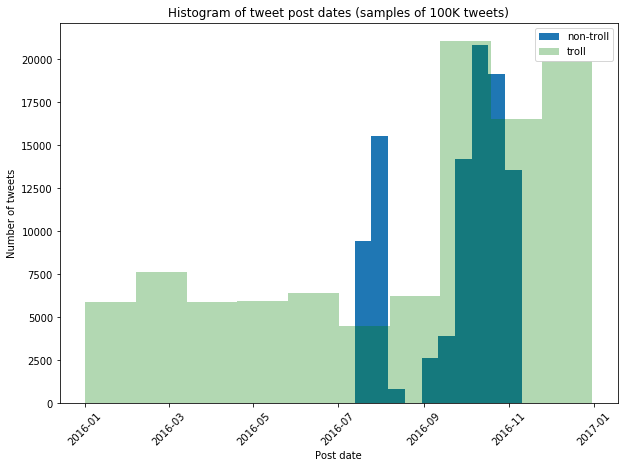

In [8]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title('Histogram of tweet post dates (samples of 100K tweets)')
ax.set_ylabel('Number of tweets')
ax.set_xlabel('Post date')

nontroll_dates = nontroll.created_at.sample(n).apply(filter_nontroll_dates).values
troll_dates = troll.publish_date.sample(n).apply(filter_troll_dates).values

ax.hist(nontroll_dates, bins=10, label='non-troll')
ax.hist(troll_dates, bins=10, label='troll', color='green', alpha=0.3)

ax.legend()
ax.tick_params(axis='x', rotation=45)

*Remark*: We see that our distributions of tweets over time are not equal. What we will have to do in our modeling is to stratify by tweet post date, and/or filter our the troll tweets that fall outside of the range of the non-troll tweets. We show an example below.

In [10]:
troll_in_range = troll.copy()

In [14]:
troll_in_range['publish_date'] = troll_in_range['publish_date'].apply(pd.to_datetime)

In [15]:
troll_in_range = troll_in_range[
    (troll_in_range.publish_date >= '2016-07-01') & 
    (troll_in_range.publish_date <= '2016-11-10')]

In [16]:
troll_in_range.shape

(168127, 16)

In [19]:
troll_in_range.to_csv('data/troll_jun_to_nov')

## Corrected distributions

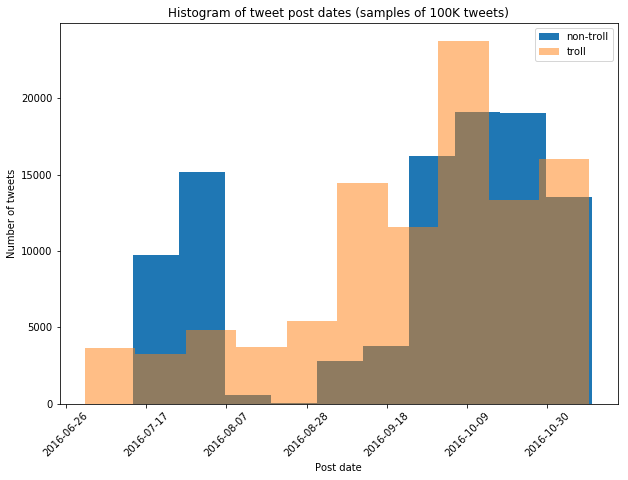

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title('Histogram of tweet post dates (samples of 100K tweets)')
ax.set_ylabel('Number of tweets')
ax.set_xlabel('Post date')

nontroll_dates = nontroll.created_at.sample(n)
troll_dates = troll_in_range.publish_date.sample(n)

ax.hist(nontroll_dates, bins=10, label='non-troll')
ax.hist(troll_dates, bins=10, label='troll', alpha=0.5)

ax.legend()
ax.tick_params(axis='x', rotation=45)

*Remark*: now the post dates line up much more closely, and we can be more confident that the underlying topics are more closely aligned, and that our machine learning models will pick up on troll-like behavior, instead of topics.

## Distributions of followers

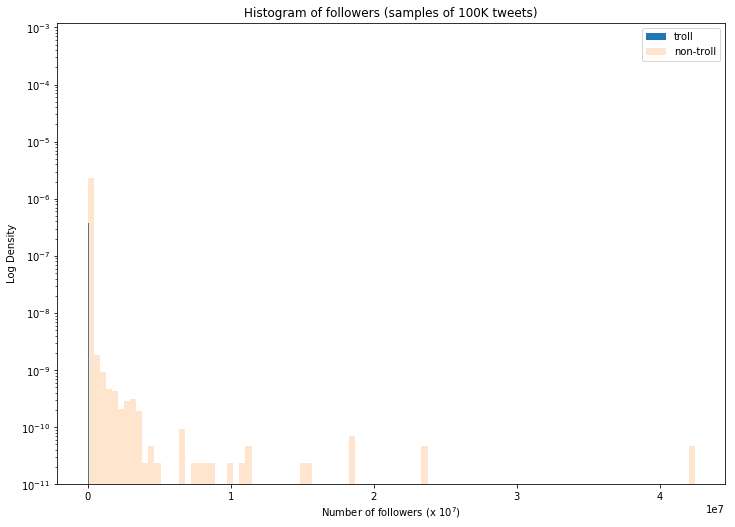

In [35]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
fig.tight_layout()

ax.set_title('Histogram of followers (samples of 100K tweets)')
ax.set_ylabel('Log Density')
ax.set_xlabel('Number of followers (x $10^7$)')

troll_followers = troll.followers.sample(n)
nontroll_followers = nontroll.followers.sample(n)

ax.hist(troll_followers, bins=100, label='troll', density=True, log=True)
ax.hist(nontroll_followers, bins=100, label='non-troll', density=True, log=True, alpha=0.2)

ax.legend()
plt.show()

*Remark*: We see that the non-troll tweets are generally associated with a much wider distribution of followers. This makes sense, and is partially a result of a small number of Twitter user anomalies (e.g. the user on the far right with ~42 million followes!).

## Distributions of Following

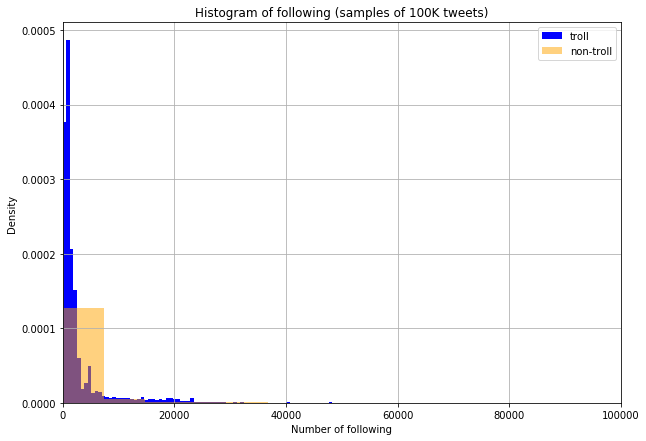

In [36]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title('Histogram of following (samples of 100K tweets)')
ax.set_ylabel('Density')
ax.set_xlabel('Number of following')
troll.following.sample(n).hist(ax=ax, bins=100, label='troll', color='blue', alpha=1, density=True)
nontroll.following.sample(n).hist(ax=ax, bins=100, label='non-troll', color='orange', alpha=0.5, density=True)
ax.set_xlim(0, 100000)
ax.legend()
plt.show()

*Remark*: we again see that the distribution of the number of users that a given Twitter user is following is much wider for non-trolls than for trolls. This makes intuitive sense as we would expect an authentic user to be following a larger, more varied set of users; while a troll, because their account is based not on interest in topics but on spreading certain thoughts, may just follow users that help them accomplish their goal.

## Retweets

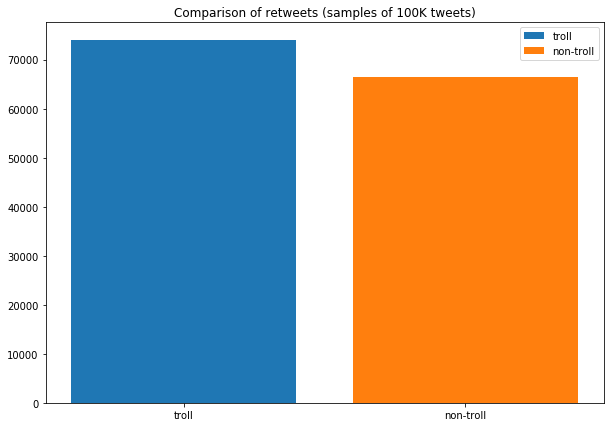

In [42]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title('Comparison of retweets (samples of 100K tweets)')

troll_retweets = np.sum(troll.retweet.sample(n))
nontroll_retweets = np.sum(nontroll.is_a_retweet.sample(n))

ax.bar(['troll'],troll_retweets,label='troll')
ax.bar(['non-troll'],nontroll_retweets,label='non-troll')

ax.legend()
plt.show()

*Remark*: it appears that trolls retweet slightly more frequently than non-trolls.

In [20]:
def has_link(text):
    return 't.co' in text

In [21]:
def compute_link_percentage(df, text_column_name):
    vc = df[text_column_name].aggregate(has_link).value_counts()
    return vc[True]/(vc[True] + vc[False])

In [22]:
link_percentage_troll = compute_link_percentage(troll_in_range, 'content')
link_percentage_non_troll = compute_link_percentage(nontroll, 'text')

## Links

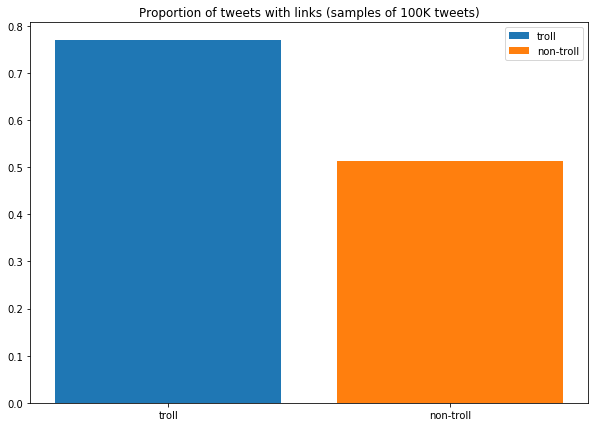

In [23]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.set_title('Proportion of tweets with links (samples of 100K tweets)')

ax.bar(['troll'],link_percentage_troll,label='troll')
ax.bar(['non-troll'],link_percentage_non_troll,label='non-troll')

ax.legend()
plt.show()

*Remark*: it appears as though trolls are more likely to post a link with their tweets. This is a useful binary feature that we can add.

In [24]:
nontroll['has_link'] = nontroll.text.apply(has_link)

In [25]:
troll_in_range['has_link'] = troll_in_range.content.apply(has_link)

In [26]:
nontroll.to_json('non_troll_data_simplified_v4.json')

In [27]:
troll_in_range.to_csv('troll_jun_to_nov_v2.csv')